# ДЗ #6. Ансамбли моделей <a id="0"></a>

### Датасет: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

* [Загрузка данных и базовые статистики](#1)
* [ML](#2)
    * Baseline
    * Bagging
    * Random Forest
    * Важность признаков
    * Stacking
* [Результат](#3)

In [1]:
# Импорт основных библиотек
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings("ignore")
np.random.seed(42)

---
<a id="1"></a>
## Загрузка данных и базовые статистики [(Наверх)](#0) 

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
filename = './data/car.csv'
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

if not os.path.exists(filename):
    car_df = pd.read_csv(url, names=column_names)
    car_df.to_csv(filename, index=False)
else:
    car_df = pd.read_csv(filename)

# Проверим корректно ли загружен CSV
car_df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [3]:
# Узнаем размер датасета
car_df.shape

(1728, 7)

In [4]:
# Узнаем свойства датасета
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
# Проверим на дубликаты и удалим если есть
car_df.drop_duplicates(inplace=True)
car_df.duplicated().sum()

0

In [6]:
# Проверим на наличие пустых данных
car_df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

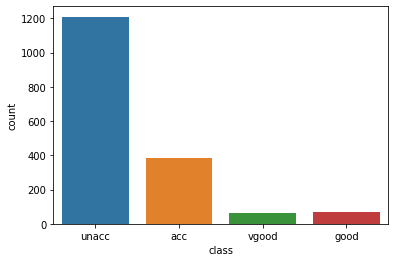

In [7]:
# Баланс классов
sns.countplot(x='class',data=car_df);

---
<a id="2"></a>
## ML [(Наверх)](#0) 

In [8]:
# Импортируем библиотеки для ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [9]:
# Процедура оценки качества
def quality_report(prediction, actual, label='', report_df=None):
    metrics_list = [accuracy_score(prediction, actual), 
                    precision_score(prediction, actual, average='weighted'), 
                    recall_score(prediction, actual, average='weighted'), 
                    f1_score(prediction, actual, average='weighted')]
    
    if report_df is None:
        report_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1']).astype('float32')
    
    report_df.loc[label, :] =  metrics_list
    
    return report_df.round(3)

In [10]:
# Обработаем категориальные переменные
#   class:    unacc, acc, good, vgood
#   buying:   vhigh, high, med, low.
#   maint:    vhigh, high, med, low.
#   doors:    2, 3, 4, 5more.
#   persons:  2, 4, more.
#   lug_boot: small, med, big.
#   safety:   low, med, high.

replace_map = {'class': {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3},
               'buying': {'vhigh': 0, 'high': 1, 'med': 2, 'low': 3},
               'maint': {'vhigh': 0, 'high': 1, 'med': 2, 'low': 3},
               'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
               'persons': {'2': 0, '4': 1, 'more': 2},
               'lug_boot': {'small': 0, 'med': 1, 'big': 2},
               'safety': {'low': 0, 'med': 1, 'high': 2}
              }

# Скопируем наш датасет и проведем замену
car_replaced_df = car_df.copy(deep=True)
car_replaced_df.replace(replace_map, inplace=True)

# Посмотрим, что получилось
car_replaced_df

,buying,maint,doors,persons,lug_boot,safety,class
0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,2,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...
1723,3,3,3,2,1,1,2
1724,3,3,3,2,1,2,3
1725,3,3,3,2,2,0,0
1726,3,3,3,2,2,1,2


In [11]:
# Подготовка сетов
X_train, X_test, y_train, y_test = train_test_split(
    car_replaced_df.drop(labels=['class'], axis=1),
    car_replaced_df['class'],
    test_size=0.3,
    stratify=car_replaced_df['class'],
    random_state=42)

### Baseline

In [12]:
# Логистическая регрессия
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
report = quality_report(log_reg.predict(X_test), y_test.values, label='log-reg (default)')

In [13]:
# Support vectors (rbf)
svc = svm.SVC(kernel='rbf', gamma='auto', random_state=42)
svc.fit(X_train, y_train)
report = quality_report(svc.predict(X_test), y_test.values, label='svm (rbf)', report_df=report)

In [14]:
# Decision Tree
dtc = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)
report = quality_report(dtc.predict(X_test), y_test.values, label='tree (depth=5)', report_df=report)

### Bagging

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
report = quality_report(bag_clf.predict(X_test), y_test.values, label='bagging', report_df=report)

### Random Forest

In [16]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)
report = quality_report(rfc.predict(X_test), y_test.values, label='forest', report_df=report)

### Важность признаков

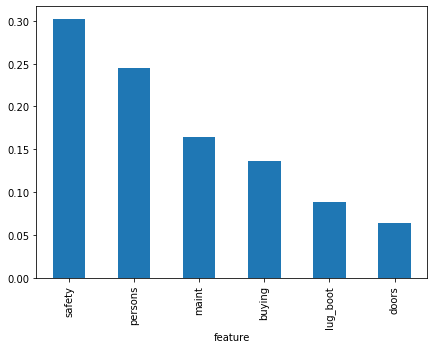

In [17]:
# Сформируем диаграмму влияния коэффициентов на целевую переменную
featureImportance = pd.DataFrame({"feature": car_replaced_df.drop('class',axis=1).columns, 
                                  "importance": rfc.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(7, 5));

### Stacking

In [18]:
# Разобъем тестовую выборку на сеты для обучения и проверки
X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [19]:
# Обучим модели SVM и RandomForest
svc.fit(X_in, y_in)
rfc.fit(X_in, y_in);

In [20]:
# Обучим LogisticRegression на предсказаниях SVM и RandomForest
log_reg.fit(np.c_[svc.predict(X_out), rfc.predict(X_out)], y_out);

In [21]:
report = quality_report(log_reg.predict(np.c_[svc.predict(X_test), rfc.predict(X_test)]),
                        y_test.values, label='stacking', report_df=report)

---
<a id="3"></a>
## Результат [(Наверх)](#0) 

In [22]:
report

,Accuracy,Precision,Recall,F1
log-reg (default),0.800,0.821,0.800,0.808
svm (rbf),0.956,0.959,0.956,0.956
tree (depth=5),0.869,0.904,0.869,0.880
bagging,0.929,0.944,0.929,0.930
forest,0.961,0.965,0.961,0.962
stacking,0.942,0.952,0.942,0.945


**Вывод:** Лучший результат у **RandomForestClassifier**